<a href="https://colab.research.google.com/github/nadavschwalb/image_processing/blob/main/Lab3_Student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 3 – Quantization and Color Histogram Equalization**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# change working directory and verify files are accessible
%cd '/content/drive/My Drive/image_processing/Lab_3'
%ls -l




/content/drive/My Drive/image_processing/Lab_3
total 12211
-rw------- 1 root root 2366097 Nov 22 13:03 Final_report_Lab3.ipynb
-rw------- 1 root root 1563314 Nov 22 13:05 Final_report_Lab3.pdf
-rw------- 1 root root  254217 Nov 11 14:12 grumpy_cat.bmp
-rw------- 1 root root 1045472 Nov 18 13:34 initialize_camshift.ipynb
-rw------- 1 root root  728708 Nov 11 14:11 initialize_camshift.pdf
-rw------- 1 root root  868598 Nov 17 18:16 landscape.bmp
-rw------- 1 root root 2300671 Nov  9 17:15 MOT16-04-trimmed.mp4
-rw------- 1 root root 3329701 Nov 18 13:55 output.mp4
-rw------- 1 root root   26768 Nov 22 13:06 printtopdf.ipynb
-rw------- 1 root root   17496 Nov 17 19:22 WeatherVane.bmp


**Import the necessary libraries for Lab 3:**

In [3]:
%matplotlib inline 
import numpy as np
import cv2
import matplotlib.pylab as plt
from skimage import transform,io, color , img_as_ubyte
from sklearn import cluster
from sklearn.utils import shuffle

# Part 1: Quantization
___

1. Insert your function quant_img(img, N) from the preliminary report.

In [4]:
def quant_img(img,N):
  if not isinstance(N,int) or N <= 0:
    raise ValueError("N must be int greater than zero")
  quant = int(256/N)
  print(f"quantizing to {N} quants of size {quant}")
  return (img/quant).astype('uint8')*quant



2. Load the image of your choise as gray scale image and perform uniform quantization on your image to **2, 4, 8, 16, 32 and 64** gray levels.   
    From which quantization factor do you observe the problem of **false contours**? Attach relevant examples from the quantized images to demonstrate your answer.

quantizing to 2 quants of size 128
quantizing to 4 quants of size 64
quantizing to 8 quants of size 32
quantizing to 16 quants of size 16
quantizing to 32 quants of size 8
quantizing to 64 quants of size 4


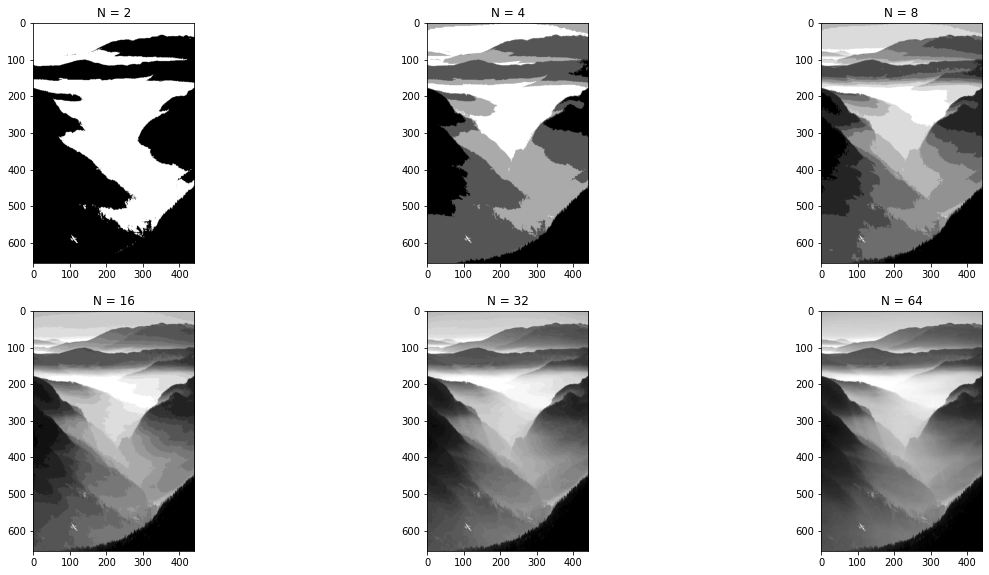

In [5]:
img = io.imread('landscape.bmp')
grayscale_img = color.rgb2gray(img)
grayscale_img= img_as_ubyte(grayscale_img)
plt.figure(figsize=(20,15))
for i in range(1,7):
  plt.subplot(330 + i)
  plt.title(f"N = {2**i}")
  plt.imshow(quant_img(grayscale_img,2**i),cmap='gray')


in N =2 ,4 and 8 we can clearly see false contures esspecially in the bright areas. we chose an image that has very smooth change in color so we can clearly see false countures where ther shouldn't be an edge



quantizing to 4 quants of size 64
quantizing to 64 quants of size 4


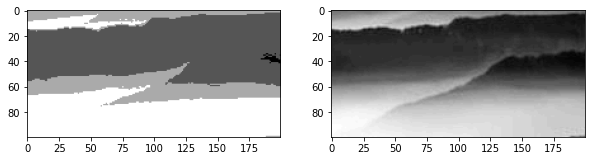

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(quant_img(grayscale_img,4)[100:200,200:400],cmap='gray')
plt.subplot(122)
plt.imshow(quant_img(grayscale_img,64)[100:200,200:400],cmap='gray')
plt.show()

3. Use the supplied function *imnoise()*, that adds Gaussian noise, on the image before quantization and test the effect on the false contours problem. Use zero mean noise with several values of variance.   
    You can use the quantization level that you chose in the previous section.
    
    What value of variance yields the optimal result? Attach examples of the quantized images with optimal and non-optimal variance values.

In [7]:
def imnoise(img, mean, std):
    noisy_img = img + np.random.normal(mean, std, img.shape)
    return np.clip(noisy_img, 0, 255)  # keep the bounds 

quantizing to 4 quants of size 64
quantizing to 8 quants of size 32
quantizing to 16 quants of size 16
quantizing to 4 quants of size 64
quantizing to 8 quants of size 32
quantizing to 16 quants of size 16
quantizing to 4 quants of size 64
quantizing to 8 quants of size 32
quantizing to 16 quants of size 16


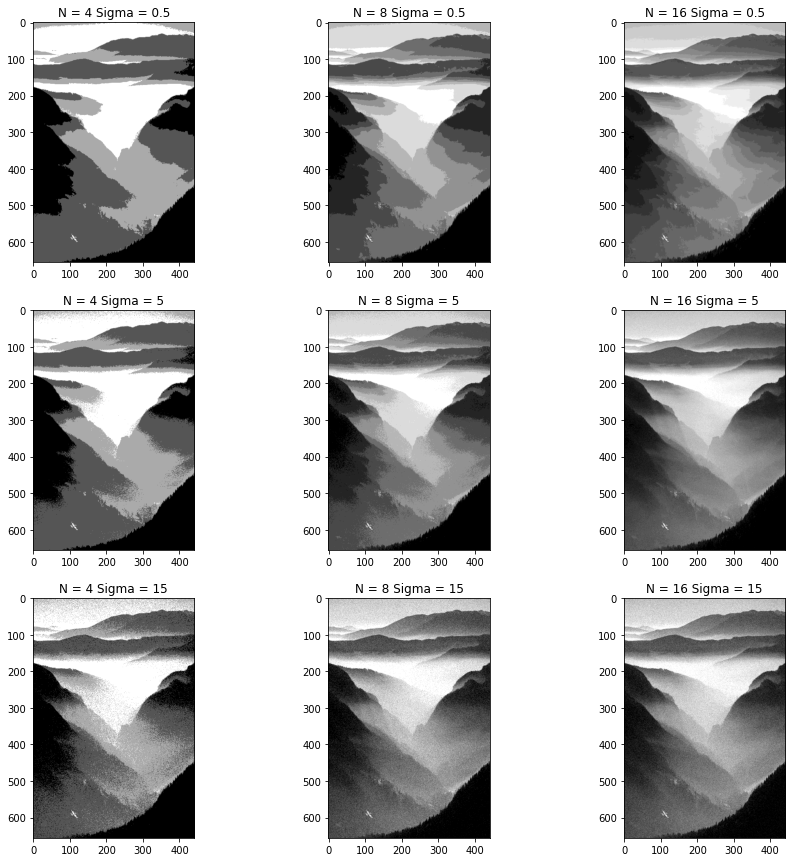

In [8]:
variances = [0.5,5,15]
quant_factors = [4,8,16]
plot_grid = len(variances)*100 + len(quant_factors)*10 + 1

plt.figure(figsize=(15,15))
for i,sigma in enumerate(variances):
  for j,N in enumerate(quant_factors):
    plt.subplot(plot_grid + i*len(quant_factors) +j)
    plt.title(f"N = {N} Sigma = {sigma}")
    uniform_quant_image = quant_img(imnoise(grayscale_img,0,sigma),N)
    plt.imshow(uniform_quant_image,cmap='gray')


adding some noise to the image makes sure that some of adjasent pixels will fall in diffrent quantization ranges and help "blend" the false contures. we found that a sigma of 5 is ideal.

a larger sigma results in clear image noise (salt and pepper)

quantizing to 8 quants of size 32
quantizing to 8 quants of size 32
quantizing to 8 quants of size 32


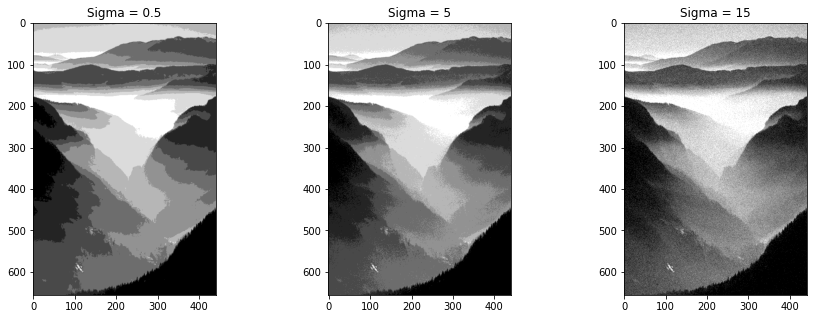

In [9]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(quant_img(imnoise(grayscale_img,0,0.5),8),cmap='gray')
plt.title("Sigma = 0.5")
plt.subplot(132)
plt.imshow(quant_img(imnoise(grayscale_img,0,5),8),cmap='gray')
plt.title("Sigma = 5")
plt.subplot(133)
plt.imshow(quant_img(imnoise(grayscale_img,0,15),8),cmap='gray')
plt.title("Sigma = 15")
plt.show()

4. perform quantization on your image using K-means to **2, 4, 8, 16, 32 and 64** gray levels. You may use the provided function. Plot the resulting histograms of both methods. What is the main difference?
    Compare your results to the results from the previous section.

In [10]:
def kmeans_quant_img(img,N):
    m,n = img.shape
    np.random.seed(0)
    image_array = img.reshape(-1,1)
    image_array_sample = shuffle(image_array, random_state=0)[:1000]
    kmeans = cluster.KMeans(n_clusters= N).fit(image_array_sample)   
    labels = kmeans.predict(image_array)
    q_img = np.zeros_like(img)
    label_idx = 0
    for i in range(m):
        for j in range(n):
            q_img[i][j] = kmeans.cluster_centers_[labels[label_idx]]
            label_idx += 1

    return q_img

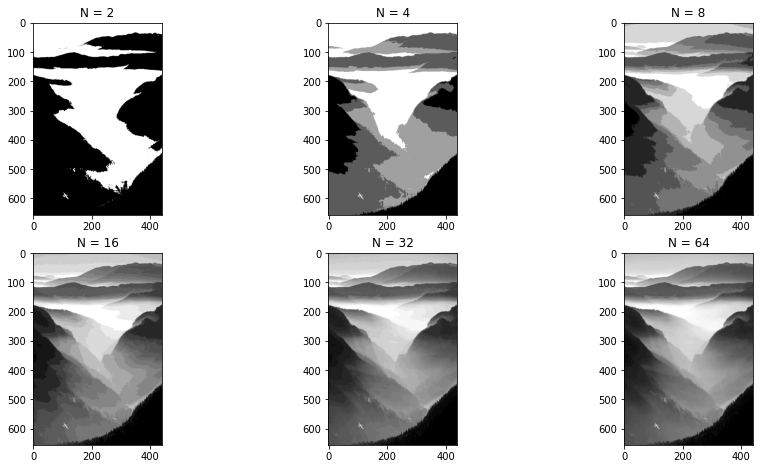

In [11]:
plt.figure(figsize=(15,12))
kmeans_quant_dict = {}
for i in range(1,7):
  plt.subplot(330 + i)
  plt.title(f"N = {2**i}")
  N_kmeans_quant_image = kmeans_quant_img(grayscale_img,2**i)
  plt.imshow(N_kmeans_quant_image,cmap='gray')
  kmeans_quant_dict[f"N = {2**i}"] = N_kmeans_quant_image



In [12]:
uniform_quant_dict = {}
for i in range(1,7):
  uniform_quant_image = quant_img(imnoise(grayscale_img,0,5),2**i)
  uniform_quant_dict[f"N = {2**i}"] = uniform_quant_image

quantizing to 2 quants of size 128
quantizing to 4 quants of size 64
quantizing to 8 quants of size 32
quantizing to 16 quants of size 16
quantizing to 32 quants of size 8
quantizing to 64 quants of size 4


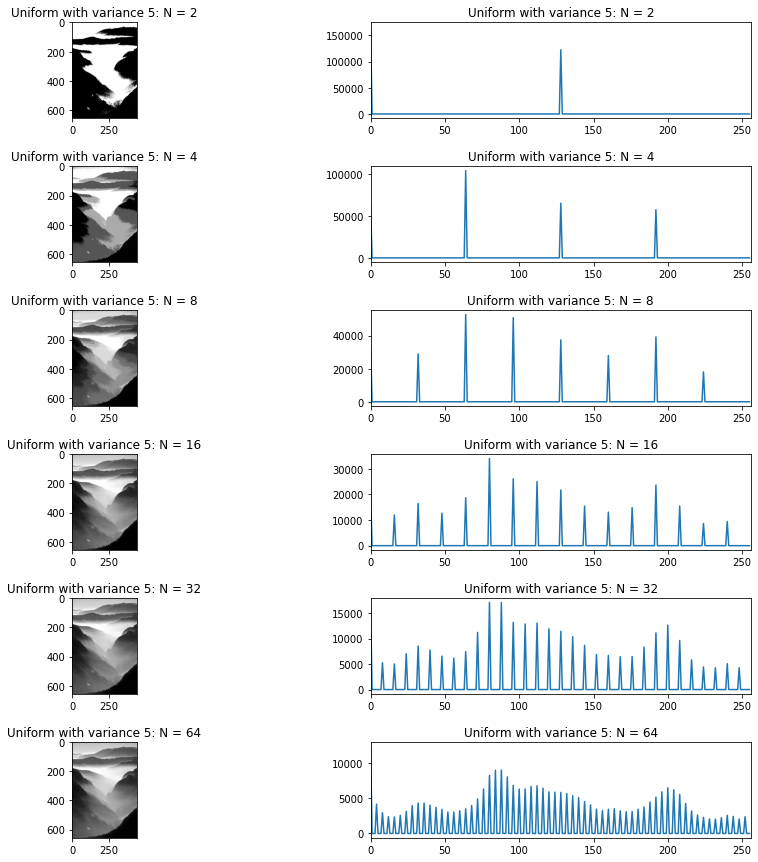

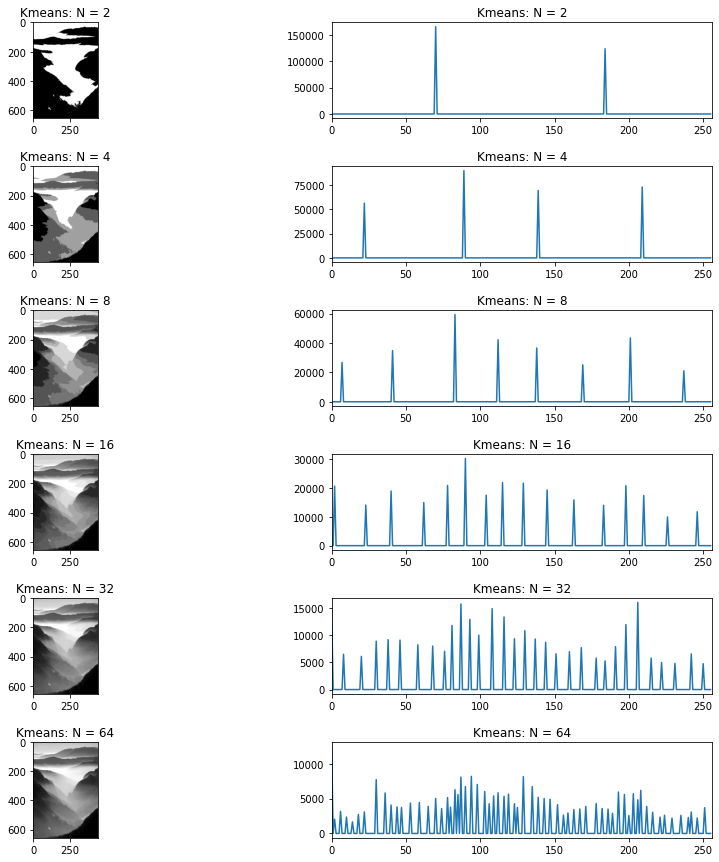

In [13]:

def plot_image_hists(image_dict,title):
  plt.figure(figsize=(15,15))
  for i,key in enumerate(image_dict.keys()):
    plt.subplot2grid((6,2),(i,0))
    plt.title(f"{title}: {key}")
    plt.imshow(image_dict[key], cmap='gray')
    plt.subplot2grid((6,2),(i,1))
    plt.title(f"{title}: {key}")   
    histr = cv2.calcHist([image_dict[key]],[0],None,[256],[0,256])
    plt.plot(histr)
    plt.xlim([0,256])
    plt.subplots_adjust(hspace=.5)

plot_image_hists(uniform_quant_dict,"Uniform with variance 5")
plot_image_hists(kmeans_quant_dict, "Kmeans") 


in uniform quantization we devide the data by fixed intervals at 256/N distances and that why in the historgarms of the uniform quantization all the spikes are uniformly distributed

on the other hand in Kmean we use the data itself to find the threasholds and so we get a more adapted quantization to fit the image. that is why the spike are not uniformly destirbuted in the histograms

# Part 2: Color Histogram Equalization
___

Use the supplied function hist_demo().  
* Observe the following demonstrations:
  * Contrast stretching.
  * Histogram equalization.

In [14]:
def hist_demo(img):
    # Contrast stretching
    img_dbl = np.float64(img)
    min_im = np.min(np.min(img_dbl))
    max_im = np.max(np.max(img_dbl))
    img_stretched_contrast = np.uint8(255*(img_dbl-min_im)/(max_im-min_im))
    
    # Histogram equalization
    img_hist_eq = cv2.equalizeHist(img) 
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    ax = axes.ravel()
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title("Original image")
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    ax[1].plot(hist)
    ax[1].set_title("Original image histogram")  
    plt.tight_layout(); plt.show()
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    ax = axes.ravel()
    ax[0].imshow(img_stretched_contrast, cmap='gray')
    ax[0].set_title("Contrast stretching image")
    hist = cv2.calcHist([img_stretched_contrast],[0],None,[256],[0,256])
    ax[1].plot(hist)
    ax[1].set_title("Contrast stretching histogram")
    plt.tight_layout(); plt.show()
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    ax = axes.ravel()
    ax[0].imshow(img_hist_eq, cmap='gray')
    ax[0].set_title("Histogram equalization image")
    hist = cv2.calcHist([img_hist_eq],[0],None,[256],[0,256])
    ax[1].plot(hist)
    ax[1].set_title("Histogram equalization histogram")
    plt.tight_layout(); plt.show()

1. Load a **gray image** of your choise ans test these demonstrations. Make sure that the image you choose is indeed affected by both operations.   
    On which images contrast stretching won’t affect?  On which images histogram equalization won’t affect?
    
    Note: 
    If you are experiencing any errors, try to convert the image to uint8 with image_as_ubyte (as we did in the first lab) before using the suplied function.

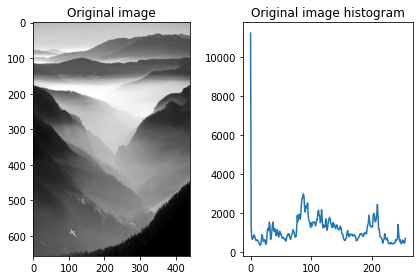

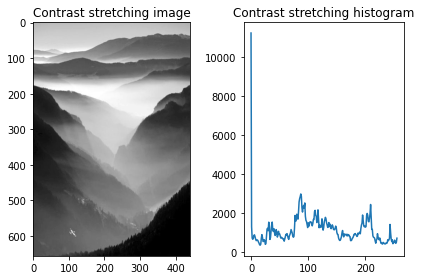

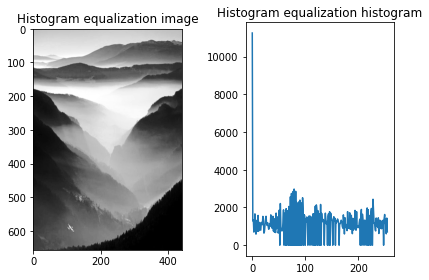

In [15]:
hist_demo(grayscale_img)


the histogram of an image that has a min value of 0 and a max value of 255 (in the case of an 8 bit image) will not be streached by contrast streaching since its histograms range is already full. 

as you can see in the image we chose there are true blacks and true whites and so the histogram stayed the same

only an image in which all the pixel are uniformly distributed between all available values will not be changed by histogram equalization. this is beacuse the PDF is already a uniform distrebution

in our image we can see slight changes in the histogram that make it more uniform

**Color Histogram Equalization**

2. We now expand Historgram Equalization to color images (RGB).
Write a new function ***hist_eq_rbg(img)*** which performs Histogram Equalization on an RGB image, equalizing each one of its color channels independently (Hint: use the given 1D function demonstrated above). Apply your function on your color image and display the results. Display also the initial and modified channelwise histograms. Are the original colors preserved? Explain.


In [16]:
def hist_eq_rbg(img):
  plt.imshow(img)
  plt.show()
  channels = cv2.split(img)
  channel_titles = ('R','g','B')
  channel_eq = []
  plt.figure(figsize=(15,10))
  for i,channel in enumerate(channels):

    plt.subplot2grid((3,4),(i,0))
    plt.title(f"original {channel_titles[i]}")
    plt.imshow(channel,cmap='gray')

    plt.subplot2grid((3,4),(i,1))
    plt.title(f"original {channel_titles[i]}")
    plt.plot(cv2.calcHist([channel],[0],None,[256],[0,256]))
    plt.xlim([0,256])

    channel_eq.append(cv2.equalizeHist(channel))

    plt.subplot2grid((3,4),(i,2))
    plt.title(f"equelized {channel_titles[i]}")
    plt.imshow(channel_eq[-1],cmap='gray')

    plt.subplot2grid((3,4),(i,3))
    plt.title(f"equelized {channel_titles[i]}")
    plt.plot(cv2.calcHist([channel_eq[-1]],[0],None,[256],[0,256]))
    plt.xlim([0,256])
  plt.show()
  
  plt.imshow(cv2.merge(np.array(channel_eq)))
  plt.show()


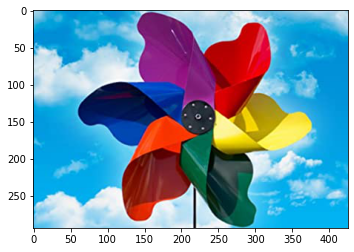

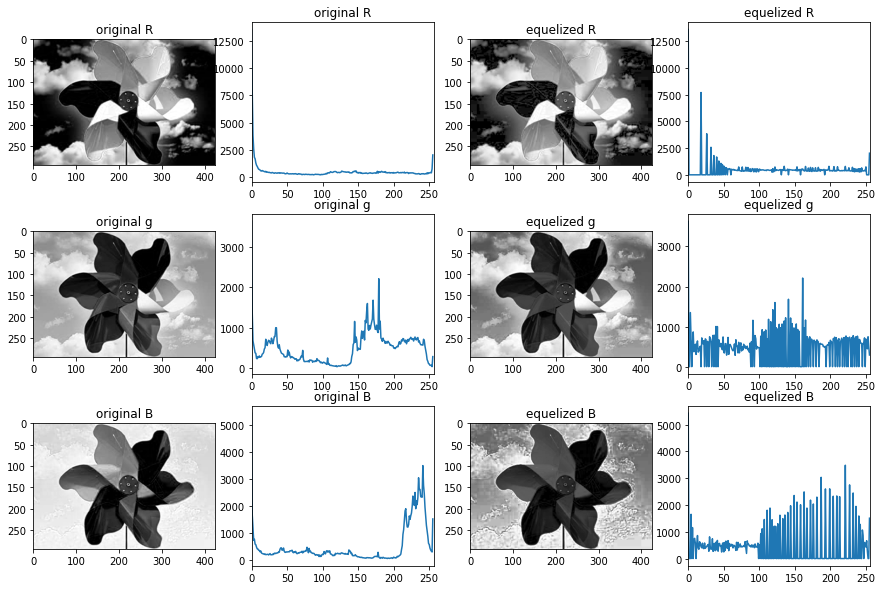

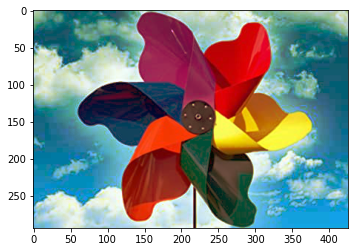

In [17]:
color_img = io.imread('WeatherVane.bmp')
hist_eq_rbg(color_img)


although the colors are somewhat preserved the resulting image looks unnatural because the histogram equalization tried to intensify colors where there wern't supposed to be inorder to equlilize the histogram

3. Suggest another approach, which would enable preserving the image colors. (Hint: consider converting to a different color space. Is there a color space, in which the color histogram equalization can be reduced to a 1D problem?)

we will convert the image to HSV color space and equlize only on the value channel since it will not effect the color distrebution only the brightness.
after equalization we will merge it and convert it back to rgb

4. Implement your approach in a new function called ***hist_eq_color*** and apply it on your color image. Display the modified image. Are the results better? (Remember to convert your image back to RGB when comparing). 

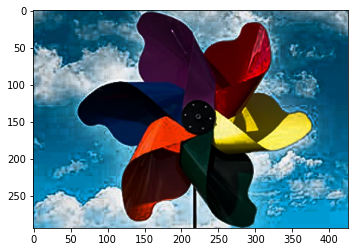

In [18]:
def hist_eq_color(img):
  hsv_img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
  channels = cv2.split(hsv_img)
  eq_V = cv2.equalizeHist(channels[2])
  eq_hsv_img = cv2.merge(np.array([channels[0],channels[1],eq_V]))
  return cv2.cvtColor(eq_hsv_img,cv2.COLOR_HSV2RGB)

eq_color_img = hist_eq_color(color_img)
plt.imshow(eq_color_img)
plt.show()

We can see that the result image we got here is better in terms of preserving the colors than the result we got when we dirctely equalizied a RGB image. The reason for it is because we equalized only the Value channel which is not effect the colors.

# Part 3: Camshift Algorithm


1. We now test the Camshift algorithm for video tracking, as explained in the Lab Manual. Given is a demo script, which loads a short video file 'MOT16-04-trimmed.mp4' from the MOT16 dataset and writes a new video file 'output.mp4' displaying the tracked object. Modify the initial ROI coordinates so that the algorithm tracks an object to your liking and observe the results.

2. Attach several captured frames of the tracked object to your report and answer the following: 
* What color space is used here for tracking and why? 
* What is the main disadvantage of the given algorithm?

Write your answer here

In [19]:
% ls

Final_report_Lab3.ipynb    initialize_camshift.pdf  printtopdf.ipynb
Final_report_Lab3.pdf      landscape.bmp            WeatherVane.bmp
grumpy_cat.bmp             MOT16-04-trimmed.mp4
initialize_camshift.ipynb  output.mp4


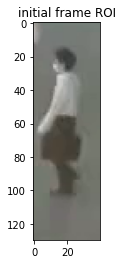

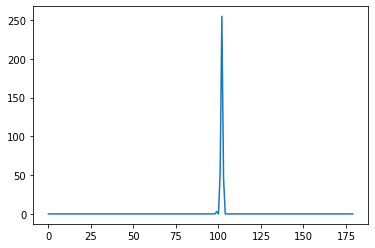

In [20]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

cap = cv2.VideoCapture('MOT16-04-trimmed.mp4')
# Default resolutions of the frame are obtained.The default resolutions are system dependent.
# We convert the resolutions from float to integer.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = cap.get(cv2.CAP_PROP_FPS)

# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
out = cv2.VideoWriter('output.mp4',cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width,frame_height))

# take first frame of the video
ret,frame = cap.read()

# setup initial location of window
#### INSERT THE ROI VALUES HERE ###
x,h,y,w = 550, 130, 90, 40 
track_window = (x,y,w,h)

# set up the ROI for tracking
roi = frame[y:y+h, x:x+w]
plt.title("initial frame ROI")
plt.imshow(roi)
plt.show()
# convert ROI to HSV
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# create ROI normalized histogram
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

plt.plot(roi_hist)
plt.show()
# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

while(1):
    ret ,frame = cap.read()

    if ret == True:
        # convert frame to HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # get probabilty map
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)

        # apply meanshift to get the new location
        ret, track_window = cv2.CamShift(dst, track_window, term_crit)
        
        # draw window on frame
        pts = cv2.boxPoints(ret)
        pts = np.int0(pts)
        img2 = cv2.polylines(frame,[pts],True, 255,2)
        k = cv2.waitKey(60) & 0xff
        
        if k == 27:
            break
        else:
            # Write the frame into the file 'output.avi'
            out.write(img2)

    else:
        break

cv2.destroyAllWindows()
cap.release()
out.release()

CAMshift uses HSV for tracking since it can correct for diffrenses in brighness without changing the underlaying colors in the H and S channels aren't changed. so the algorithem can correct for diffrent lighting conditions

after trying to track three moving targets unsuccesfully we track the above target for a few frames, after which the person passed in front of anthor similarly colored figure where appon the bounding box jumped onto the new figure. this illusstrates one of the main issues with CAMshift in that the histogram of a figure is not unique. this is esspecial obvious during oclussion where one object is hiding another and the algorithm can no longer track the original histogram.

in the inital people we tried to track the algorithm could not converge on a single center of mass and would hit its termination criteria on every frame and thus the bounding box would diverge in size and get bigger.


In [28]:
%pwd

'/content/drive/My Drive/image_processing/Lab_3'

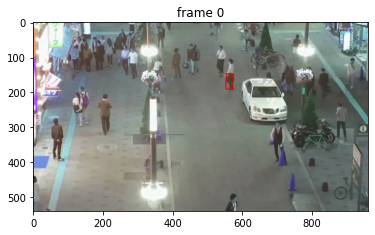

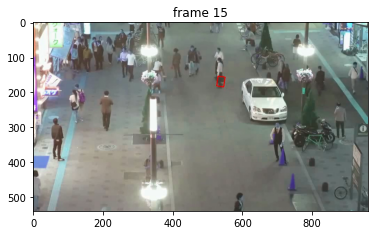

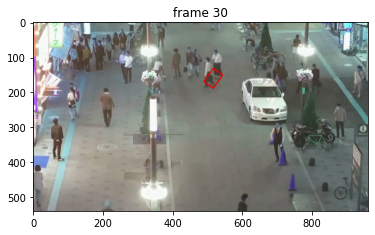

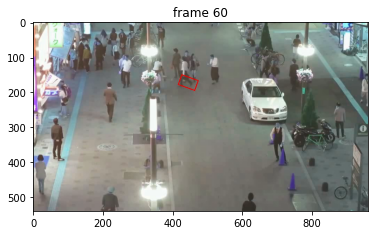

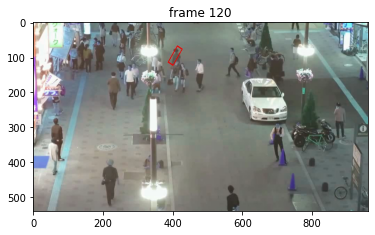

In [38]:
#grab tracking screenshots
cap = cv2.VideoCapture('output.mp4')

frame_count = 0
grab_frames = [0,15,30,60,120]
while(True):
  ret, frame = cap.read()

  if ret == True:
    if len(grab_frames) >0:
      if frame_count == grab_frames[0]:
        cv2.imwrite(f'/content/drive/My Drive/image_processing/Lab_3/{frame_count}.bmp',frame)
        plt.imshow(frame)
        plt.title(f"frame {frame_count}")
        plt.show()
        grab_frames.pop(0)
      frame_count += 1
      k = cv2.waitKey(33) & 0xff

    if k == 27:
      break
  else:
    break
